In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import panel as pn
import itertools
import math
import param
import fsspec

pn.extension()

In [2]:
image_bucket = "ncar-cesm-pop-test/images"
fs = fsspec.filesystem("s3", anon=True)

In [3]:
files = fs.glob(f"{image_bucket}/g.e22*/*/*.png")
len(files)

4633

In [4]:
def parse_file(file):
    path = file
    file = Path(file)
    x = dict(path=path)
    if "checkpoint" in path:
        return {}
    plot_type = file.parent.stem
    casename = file.parent.parent.parts[-1]
    x["casename"] = casename
    x["plot_type"] = plot_type
    parts = file.stem.split("+")
    x["varname"] = parts[0]
    if plot_type == "timestep-global-map":
        x["plot_type"] = plot_type
        x["time"] = parts[1]
    if len(parts) > 2:
        if plot_type == "global-timeseries":
            idx = 1
        else:
            idx = 2
        for part in parts[idx:]:
            y = part.split("@")
            x[y[0]] = y[1]
            if y[0].startswith("z_t"):
                x["depth_level"] = y[1]
    return x


entries = [parse_file(file) for file in files]

In [5]:
df = pd.DataFrame(entries).dropna(subset=["path"])

df["z_t"] = df["z_t"].astype(float)
df["z_t_150m"] = df["z_t_150m"].astype(float)
df["depth_level"] = df["depth_level"].astype(float)
df["depth_level"] = df["depth_level"].fillna(-9999)
df["log_10"] = df.log_10.map(lambda x: True if x == "True" else False)
df.head()

path  \
0  ncar-cesm-pop-test/images/g.e22.G1850ECO_JRA_H...   
1  ncar-cesm-pop-test/images/g.e22.G1850ECO_JRA_H...   
2  ncar-cesm-pop-test/images/g.e22.G1850ECO_JRA_H...   
3  ncar-cesm-pop-test/images/g.e22.G1850ECO_JRA_H...   
4  ncar-cesm-pop-test/images/g.e22.G1850ECO_JRA_H...   

                              casename          plot_type           varname  \
0  g.e22.G1850ECO_JRA_HR.TL319_t13.003  global-timeseries   CaCO3_FLUX_100m   
1  g.e22.G1850ECO_JRA_HR.TL319_t13.003  global-timeseries             DpCO2   
2  g.e22.G1850ECO_JRA_HR.TL319_t13.003  global-timeseries            FG_CO2   
3  g.e22.G1850ECO_JRA_HR.TL319_t13.003  global-timeseries               NH4   
4  g.e22.G1850ECO_JRA_HR.TL319_t13.003  global-timeseries  NHx_SURFACE_EMIS   

  spatial_op time_coarsen_len    z_t  depth_level  z_t_150m  log_10  \
0  integrate               12    NaN      -9999.0       NaN   False   
1    average               12    NaN      -9999.0       NaN   False   
2  integrate               12    NaN      -9999.0       NaN   False   
3    average               12  500.0        500.0       NaN   False   
4  integrate               12    NaN      -9999.0       NaN   False   

  time_range time  
0        NaN  NaN  
1        NaN  NaN  
2        NaN  NaN  
3        NaN  NaN  
4        NaN  NaN

In [6]:
df.casename.unique()

array(['g.e22.G1850ECO_JRA_HR.TL319_t13.003',
       'g.e22.G1850ECO_JRA_HR.TL319_t13.004'], dtype=object)

In [7]:
groups = {}
grouped = df.groupby("plot_type")
for key in grouped.groups:
    groups[key] = grouped.get_group(key)
groups.keys()

dict_keys(['global-timeseries', 'histogram', 'timestep-global-map'])

In [8]:
class BaseDashboard(param.Parameterized):
    def __init__(self, **params):
        super().__init__(**params)
        self.update_data()

    def get_data(self):
        raise NotImplementedError()

    def update_data(self):
        raise NotImplementedError()

    def plot(self):
        nrows, ncols = 1, 1
        fig, ax = plt.subplots(
            nrows=nrows, ncols=ncols, figsize=(8.5, 6.5), squeeze=True
        )
        try:
            df = self.get_data()
            path = df.iloc[0].path
            with fs.open(path) as f:
                data = img.imread(f)
            ax.imshow(data)

        except Exception:
            pass

        ax.axis("off")
        plt.tight_layout()
        plt.close(fig)
        return fig


class TimestepDashboard(BaseDashboard):
    title = "## Time Slice Map"

    _df = df[(df.plot_type == "timestep-global-map")]
    casename = param.ObjectSelector(objects=sorted(_df.casename.unique()))
    variable = param.ObjectSelector(
        default="CaCO3_FLUX_100m", objects=sorted(_df.varname.unique())
    )

    depth_level = param.ObjectSelector(
        default=-9999, objects=sorted(_df.depth_level.unique().tolist())
    )
    apply_log10 = param.Selector(default=False, objects=[False, True])
    data = param.Parameter(default=None, precedence=-1)
    times = param.Parameter(default=None, precedence=-1)
    time = param.Integer()

    def get_data(self):
        df = self.data.loc[
            (self.data.time == self.times[self.time])
            & (self._df.casename == self.casename)
            & (self.data.depth_level == self.depth_level)
            & (self.data.log_10 == self.apply_log10)
        ]
        return df

    @param.depends("variable", watch=True)
    def update_data(self):
        self.data = self._df[(self._df.varname == self.variable)]
        self.param.casename.objects = sorted(self.data.casename.unique())
        self.casename = self.param.casename.objects[0]
        self.param.depth_level.objects = sorted(self.data.depth_level.unique())
        self.depth_level = self.param.depth_level.objects[0]
        self.times = sorted(self.data.time.unique())
        self.param.time.bounds = (0, len(self.times) - 1)
        self.param.apply_log10.objects = sorted(self.data.log_10.unique())
        self.apply_log10 = self.param.apply_log10.objects[0]


dd_left = TimestepDashboard(name="")
dd_right = TimestepDashboard(name="", variable="O2_ZMIN_DEPTH")

one_timestep_dashboard = pn.Column(
    dd_left.title,
    pn.Row(
        pn.Column(pn.WidgetBox(pn.Row(dd_left.param), pn.Row(dd_left.plot))),
        pn.Column(pn.WidgetBox(pn.Row(dd_right.param), pn.Row(dd_right.plot))),
    ),
)

In [9]:
class TimeseriesDashboard(BaseDashboard):
    title = "## Timeseries Plot"
    _df = df[(df.plot_type == "global-timeseries")]
    casename = param.ObjectSelector(objects=sorted(_df.casename.unique()))
    variable = param.ObjectSelector(
        default="CaCO3_FLUX_100m", objects=sorted(_df.varname.unique())
    )
    depth_level = param.ObjectSelector(
        default=-9999, objects=sorted(_df.depth_level.unique())
    )
    spatial_operation = param.Selector(objects=sorted(_df.spatial_op.unique()))
    time_coarsen_length = param.Selector(
        objects=sorted(_df.time_coarsen_len.unique())
    )

    data = param.Parameter(default=None, precedence=-1)

    def get_data(self):
        df = self.data.loc[
            (self.data.spatial_op == self.spatial_operation)
            & (self._df.casename == self.casename)
            & (self.data.depth_level == self.depth_level)
            & (self.data.time_coarsen_len == self.time_coarsen_length)
        ]
        return df

    @param.depends("variable", watch=True)
    def update_data(self):
        self.data = self._df[(self._df.varname == self.variable)]
        self.param.casename.objects = sorted(self.data.casename.unique())
        self.casename = self.param.casename.objects[0]
        self.param.spatial_operation.objects = sorted(
            self.data.spatial_op.unique()
        )
        self.spatial_operation = self.param.spatial_operation.objects[0]
        self.param.depth_level.objects = sorted(self.data.depth_level.unique())
        self.depth_level = self.param.depth_level.objects[0]
        self.param.time_coarsen_length.objects = sorted(
            self.data.time_coarsen_len.unique()
        )
        self.time_coarsen_length = self.param.time_coarsen_length.objects[0]


td_left = TimeseriesDashboard(name="")
td_right = TimeseriesDashboard(name="", variable="O2_ZMIN")
timeseries_dashboard = pn.Column(
    td_left.title,
    pn.Row(
        pn.Column(pn.WidgetBox(pn.Row(td_left.param), pn.Row(td_left.plot))),
        pn.Column(pn.WidgetBox(pn.Row(td_right.param), pn.Row(td_right.plot))),
    ),
)

In [10]:
class HistogramDashboard(BaseDashboard):
    title = "## Histogram Plot"

    _df = df[(df.plot_type == "histogram")]
    casename = param.ObjectSelector(objects=sorted(_df.casename.unique()))
    variable = param.ObjectSelector(
        default="CaCO3_FLUX_100m", objects=sorted(_df.varname.unique())
    )

    depth_level = param.ObjectSelector(
        default=-9999, objects=sorted(_df.depth_level.unique().tolist())
    )
    apply_log10 = param.Selector(default=False, objects=[False, True])
    data = param.Parameter(default=None, precedence=-1)
    times = param.Parameter(default=None, precedence=-1)
    time = param.Integer()

    def get_data(self):
        df = self.data.loc[
            (self.data.time_range == self.times[self.time])
            & (self._df.casename == self.casename)
            & (self.data.depth_level == self.depth_level)
            & (self.data.log_10 == self.apply_log10)
        ]
        return df

    @param.depends("variable", watch=True)
    def update_data(self):
        self.data = self._df[(self._df.varname == self.variable)]
        self.param.casename.objects = sorted(self.data.casename.unique())
        self.casename = self.param.casename.objects[0]
        self.param.depth_level.objects = sorted(self.data.depth_level.unique())
        self.depth_level = self.param.depth_level.objects[0]
        self.times = sorted(self.data.time_range.unique())
        self.param.time.bounds = (0, len(self.times) - 1)
        self.param.apply_log10.objects = sorted(self.data.log_10.unique())
        self.apply_log10 = self.param.apply_log10.objects[0]


hd_left = HistogramDashboard(name="")
hd_right = HistogramDashboard(name="", variable="O2_ZMIN")
histogram_dashboard = pn.Column(
    hd_left.title,
    pn.Row(
        pn.Column(pn.WidgetBox(pn.Row(hd_left.param), pn.Row(hd_left.plot))),
        pn.Column(pn.WidgetBox(pn.Row(hd_right.param), pn.Row(hd_right.plot))),
    ),
)

Row
    [0] Column(background='#659dbd')
        [0] Markdown(str)
        [1] Row
            [0] Spacer(width=10)
            [1] Markdown(str)
            [2] Spacer(width=10)
            [3] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Row
                [0] Column
                    [0] WidgetBox
                        [0] Row
                            [0] Column(margin=5, width=300)
                                [0] StaticText(value='<b></b>')
                                [1] Select(name='Casename', options=OrderedDict([('g.e22.G1850...]), value='g.e22.G1850ECO_JRA_HR.TL3...)
                                [2] Select(name='Variable', options=OrderedDict([('CaCO3_FLUX_...]), value='CaCO3_FLUX_100m')
                                [3] Select(name='Depth level', options=OrderedDict([('-9999.0', ...]), value=-9999.0)
                                [4] Select(name='Apply log10', options=OrderedDict([('False', ...]), value=False)
                                [5] IntSlider(end=59, name='Time')
                        [1] Row
                            [0] ParamMethod(method)
                [1] Column
                    [0] WidgetBox
                        [0] Row
                            [0] Column(margin=5, width=300)
                                [0] StaticText(value='<b></b>')
                                [1] Select(name='Casename', options=OrderedDict([('g.e22.G1850...]), value='g.e22.G1850ECO_JRA_HR.TL3...)
                                [2] Select(name='Variable', options=OrderedDict([('CaCO3_FLUX_...]), value='O2_ZMIN_DEPTH')
                                [3] Select(name='Depth level', options=OrderedDict([('-9999.0', ...]), value=-9999.0)
                                [4] Select(name='Apply log10', options=OrderedDict([('False', ...]), value=False)
                                [5] IntSlider(end=59, name='Time')
                        [1] Row
                            [0] ParamMethod(method)
        [1] Column
            [0] Markdown(str)
            [1] Row
                [0] Column
                    [0] WidgetBox
                        [0] Row
                            [0] Column(margin=5, width=300)
                                [0] StaticText(value='<b></b>')
                                [1] Select(name='Casename', options=OrderedDict([('g.e22.G1850...]), value='g.e22.G1850ECO_JRA_HR.TL3...)
                                [2] Select(name='Variable', options=OrderedDict([('CaCO3_FLUX_...]), value='CaCO3_FLUX_100m')
                                [3] Select(name='Depth level', options=OrderedDict([('-9999.0', ...]), value=-9999.0)
                                [4] Select(name='Spatial operation', options=OrderedDict([('integrate',...]), value='integrate')
                                [5] Select(name='Time coarsen length', options=OrderedDict([('12', ...]), value='12')
                        [1] Row
                            [0] ParamMethod(method)
                [1] Column
                    [0] WidgetBox
                        [0] Row
                            [0] Column(margin=5, width=300)
                                [0] StaticText(value='<b></b>')
                                [1] Select(name='Casename', options=OrderedDict([('g.e22.G1850...]), value='g.e22.G1850ECO_JRA_HR.TL3...)
                                [2] Select(name='Variable', options=OrderedDict([('CaCO3_FLUX_...]), value='O2_ZMIN')
                                [3] Select(name='Depth level', options=OrderedDict([('-9999.0', ...]), value=-9999.0)
                                [4] Select(name='Spatial operation', options=OrderedDict([('average', ...]), value='average')
                                [5] Select(name='Time coarsen length', options=OrderedDict([('12', ...]), value='12')
                        [1] Row
                            [0] ParamMethod(method)
        [2] Column
            [0] Markdown(str)
            [1] 
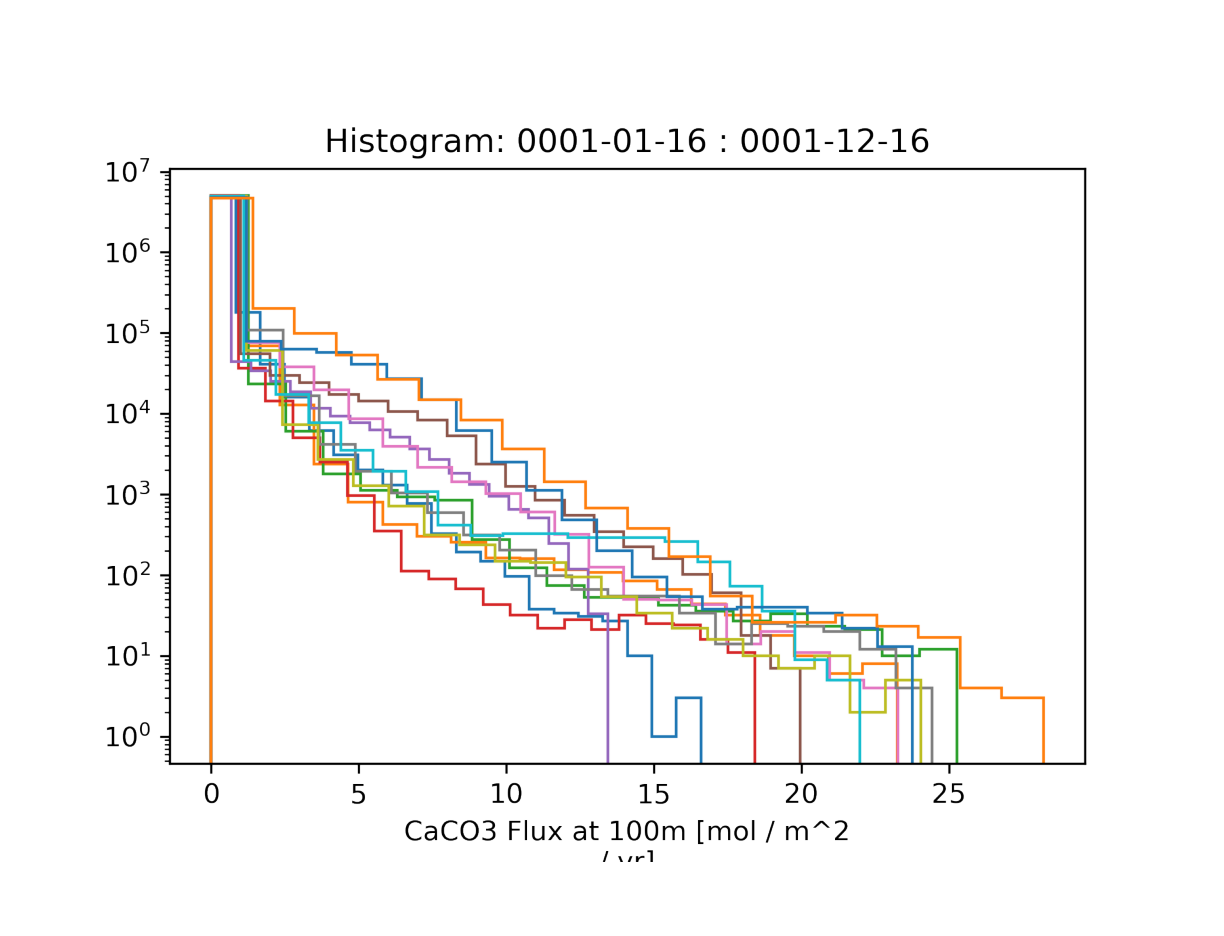
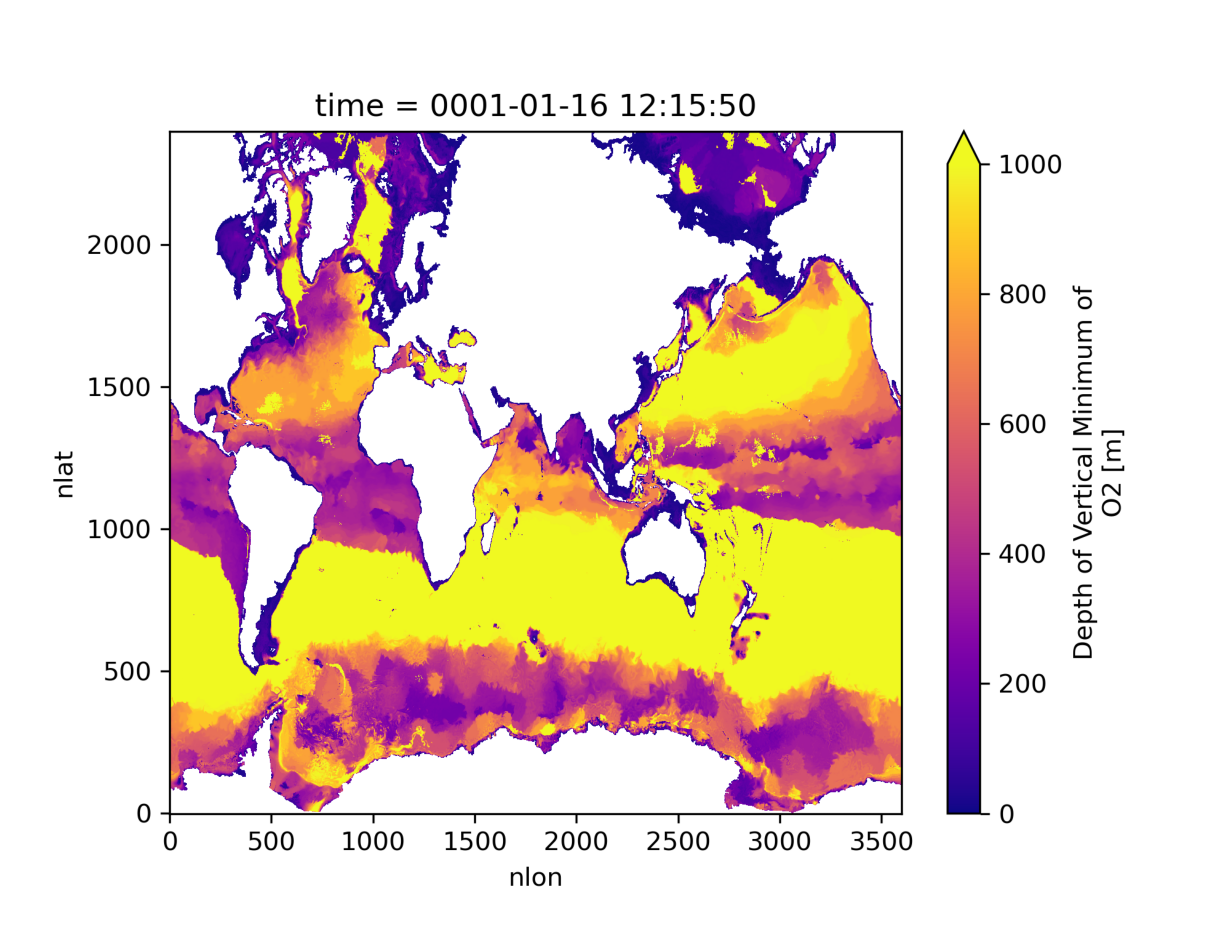
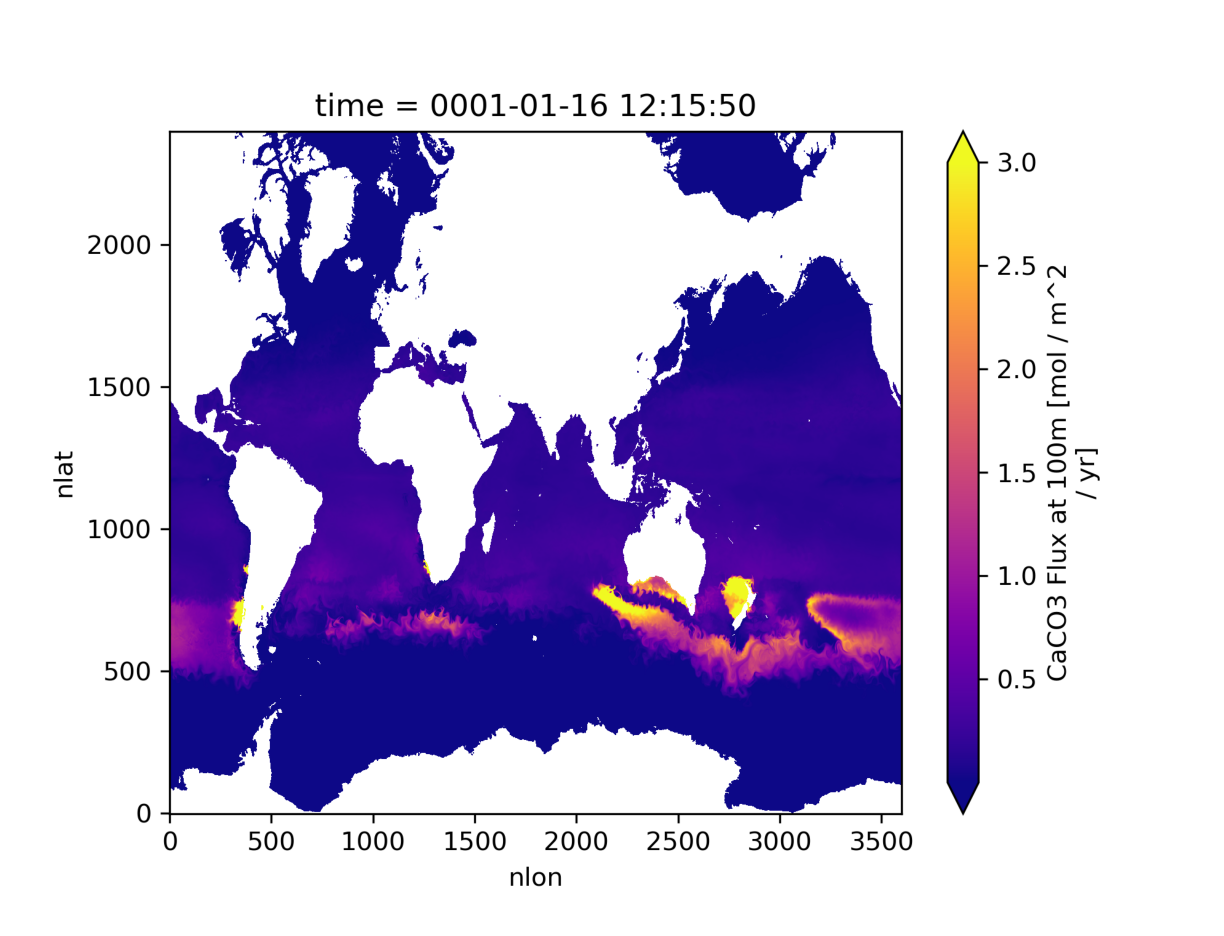
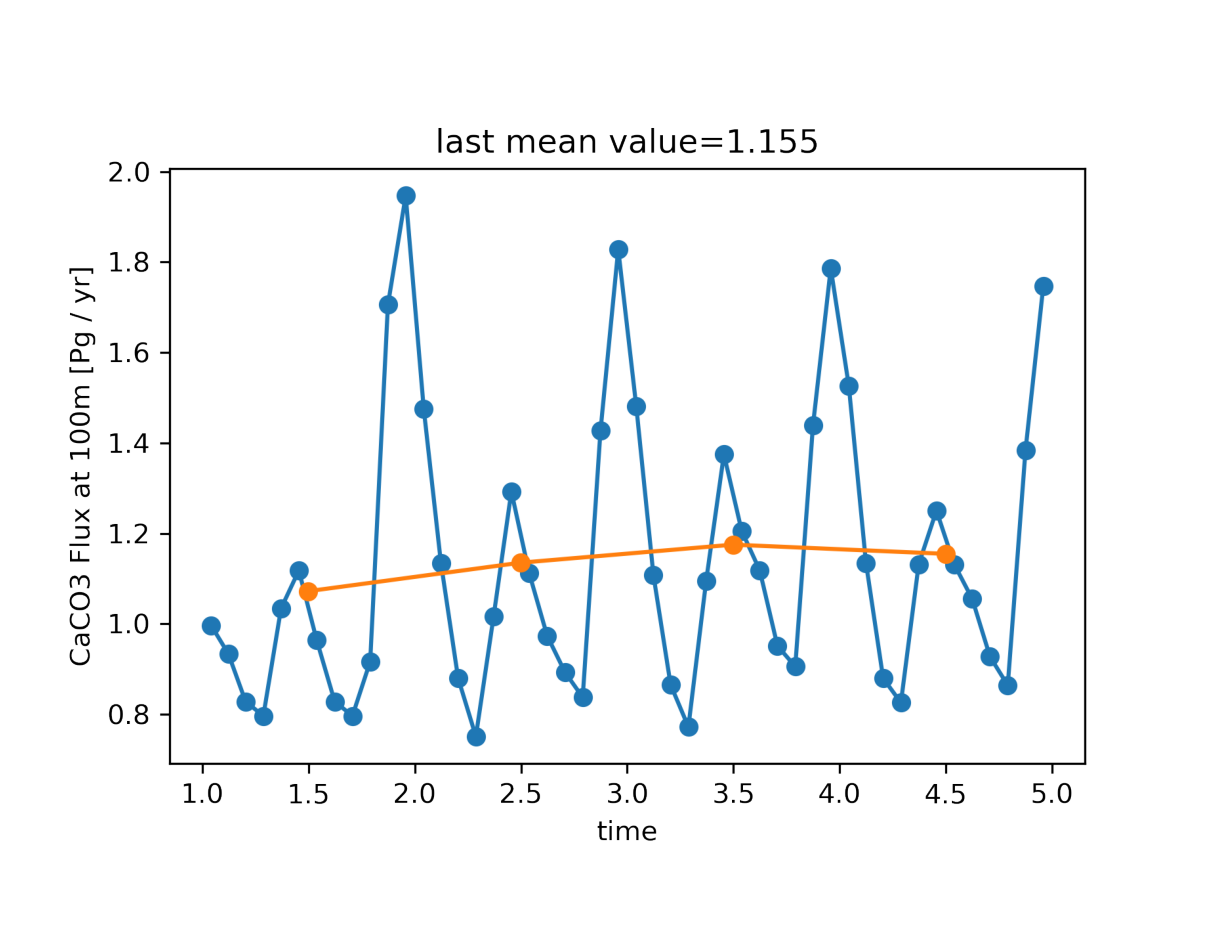
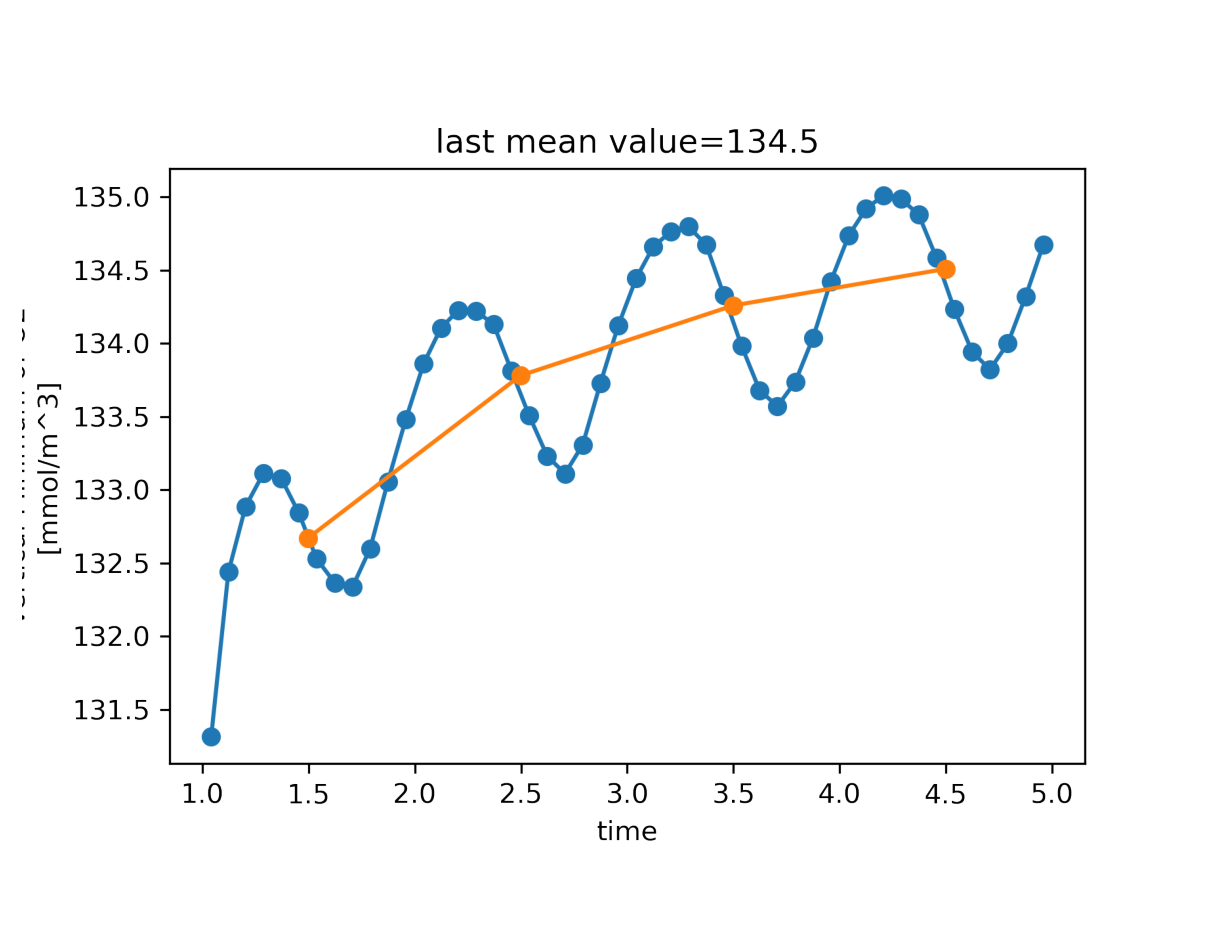
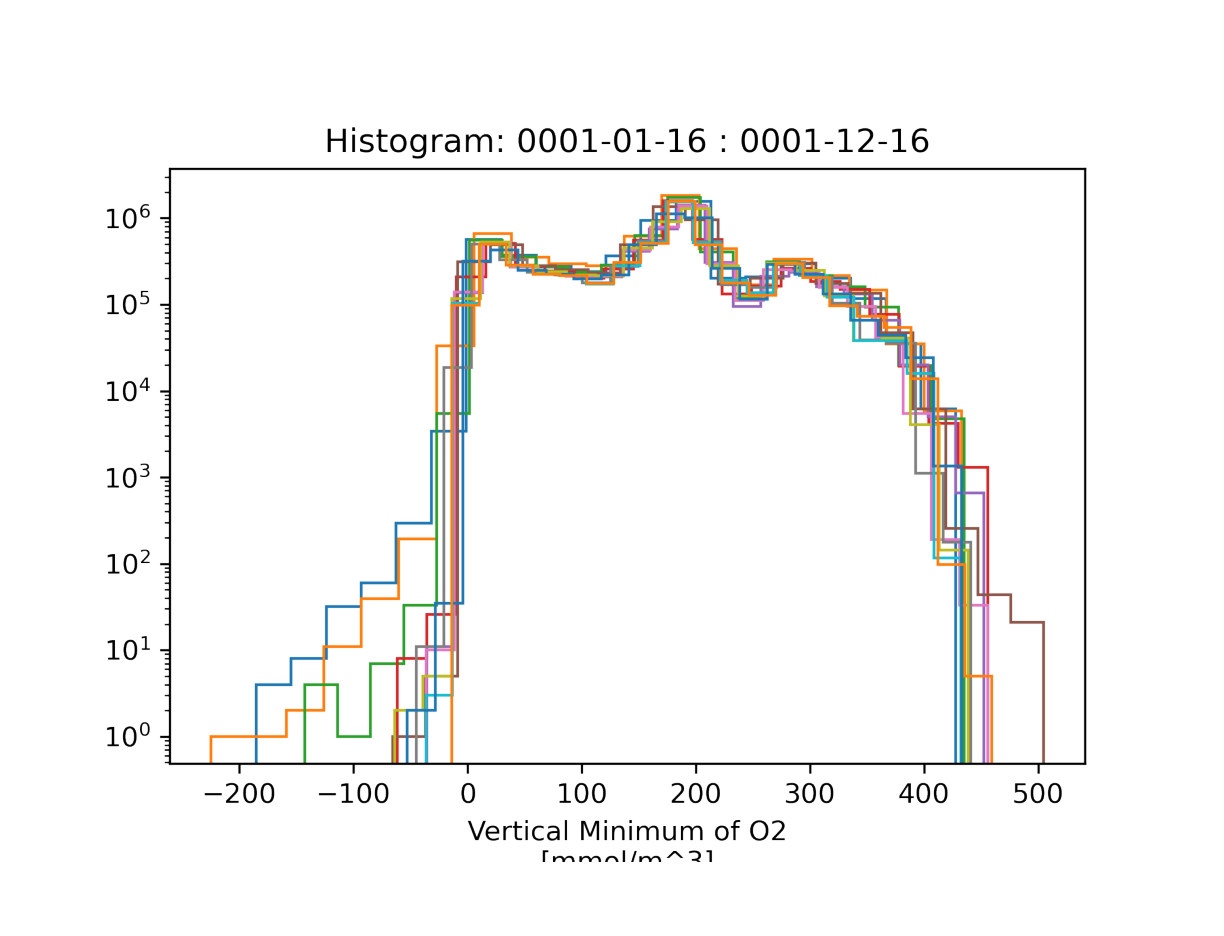

In [11]:
hv_logo = '<a href="https://holoviz.org"><img src="https://holoviz.org/assets/holoviz-logo-stacked.svg" width=80></a>'
thumbnail = '<a href="https://github.com/marbl-ecosys/"><img src="https://raw.githubusercontent.com/NCAR/cesm-lens-aws/master/thumbnail.png" width=80 height=80></a>'
menu_background = "#659dbd"
menu_text = "<div><p>0.1 degree POP / CICE run with ocean BGC</p><br><br><p><a href='https://github.com/marbl-ecosys/HiRes-CESM-analysis'>HiRes-CESM analysis repo</a></p><p><a href='https://github.com/andersy005/HiRes-CESM-dashboard'>HiRes-CESM dashboard repo</a></p></div><br><br>"
menu = pn.Column(
    menu_text,
    pn.Row(
        pn.Spacer(width=10),
        pn.Pane(thumbnail),
        pn.Spacer(width=10),
        pn.Pane(hv_logo),
    ),
    background=menu_background,
)

dashboard = pn.Row(
    menu,
    pn.Tabs(
        ("Time Slice Maps", one_timestep_dashboard),
        ("Timeseries Plots", timeseries_dashboard),
        ("Histogram Plots", histogram_dashboard),
        tabs_location="above",
    ),
)
dashboard.servable("HiRes-CESM Diagnostics Dashboard")